# <u>NSW DCCEEW training &ndash; Demo 1: Landsat data access and pre-processing</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Local cluster


<b>Contents</b>
  - [Overview](#Overview)
  - [User parameters](#User-parameters)
  - [Notebook setup](#Notebook-setup)
  - [Dask](#Dask)
  - [Data loading, pre-processing, TSS calculation](#Data-loading,-pre-processing,-TSS-calculation)
    - [Loading the Landsat data](#Loading-the-Landsat-data)
    - [Landsat data pre-processing &amp; WQ algorithm](#Landsat-data-pre-processing-&amp;-WQ-algorithm)
    - [Visualise some aspects of the WQ time series](#Visualise-some-aspects-of-the-WQ-time-series)
      - [Time gaps between observations](#Time-gaps-between-observations)
      - [Visualise some TSS time slices](#Visualise-some-TSS-time-slices)

# Overview

This series of notebooks (`NSW DCCEEW training`) provides a demonstration of some basic analyses of water quality parameter (TSS) using Landsat data (Acolite processed).

  - Demonstration notebooks
    - For audience with various skills levels
    - Get a feel for EASI / ADIAS and ODC technology
  - Demonstrates some interesting science:
    - Calculation of empirical algorithms for water quality parameters (TSS)
    - Basic statistical and trends analyses
    - Calculation of sediment flux using BoM rainfall data
  - Touches on various technical aspects:
    - JupyterLab environment and notebooks
    - Data availability and access on ADIAS and elsewhere
    - Visualisation
    - Parallelism and parallelised processing
 
# User parameters

In [1]:
### Selected river systems: lat/lon locations
riv_loc =  (151.34428, -33.5677)   # selected location -- river mouth, Haweksbury

min_longitude, max_longitude = (151.1355, 151.7047)   # ROI for visualisation purposes
min_latitude, max_latitude = (-33.8025,-33.3707)

time_range = ('2013-01-01','2025-01-01')   # selected time window: FULL LANDSAT TIME SERIES
# time_range = ('2021-06-01','2022-06-01')   # selected time window: testing

### Selected parameter to plot / visualise 
WQparam = 'TSS'          # selected WQ parameter
WQunits = 'mg/L'         # WQ units
lower_is_better = True   # whether lower WQ values are blue/red in plots
wq_log_scale = True      # whether to plot raw WQ values in log-scale

### Dask:
n_workers = None    # for local Dask cluster
# n_workers = 12; workers_mem = 8    # for Dask Gateway cluster

# Notebook setup

In [2]:
### System
import sys, os
import itertools

### Data handling
import pyproj
import numpy as np
import xarray as xr
from astropy.stats import sigma_clip
import statsmodels.api as sm

import rioxarray
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd

from shapely.affinity import translate
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

### ODC / STAC
import odc.stac
import pystac_client

### Data cube
import datacube
dc = datacube.Datacube(app="NSW_demo")

### Dask
from dask.distributed import wait

### Display / plots
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

Here making use of a couple of functions from the base EASI notebooks &ndash; these can be accessed by `git clone`-ing the following repo: `https://github.com/csiro-easi/easi-notebooks.git`

In [3]:
### Misc
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
from app_utils import display_map

# Eric's own function for getting coastline data:
exec(open("./get_coastline.py").read())

In [4]:
### Miscellaneous
if lower_is_better: 
    cmap = 'jet'
    cmap1 = 'RdBu_r'   # 'coolwarm': centre colour is grey -- 'RdBu_r': centre colour is white
else: 
    cmap = 'jet_r'
    cmap1 = 'RdBu'
    
if wq_log_scale: norm = colors.LogNorm()
else: norm = None

cmp = LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

In [5]:
from collections import Counter

def mostcommon_crs_res(dc, query):
    # Returns the most common CRS and resolution for a given DC query.
    # Adapted from 'mostcommon_crs()' from 'notebook_utils'
    """Adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py"""
    matching_datasets = dc.find_datasets(**query)
    crs_list = [str(i.crs) for i in matching_datasets]
    resx_list = [i.metadata_doc['grids']['default']['transform'][0] for i in matching_datasets]   # x-res
    resy_list = [i.metadata_doc['grids']['default']['transform'][4] for i in matching_datasets]   # y-res
    
    crs_mostcommon = None
    res_mostcommon = None
    if len(crs_list) > 0:
        # Identify most common CRS + resolution
        crs_counts = Counter(crs_list)
        crs_mostcommon = crs_counts.most_common(1)[0][0]
        
        resx_counts = Counter(resx_list)
        resy_counts = Counter(resy_list)
        res_mostcommon = (resx_counts.most_common(1)[0][0], resy_counts.most_common(1)[0][0])
    else:
        logger.warning('No data was found for the supplied product query')
    return crs_mostcommon, res_mostcommon

# Dask

Flexible open-source library for parallel and distributed computing in Python. It provides integration with various Python libraries like NumPy, Pandas, and scikit-learn to enable parallel execution across multiple cores.

In [6]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

### Use the following to shut down this cluster:
# cluster.close()
# client.shutdown()

Local cluster dashboard: https://hub.adias.aquawatchaus.space/user/eric.lehmann/proxy/8787/status


LocalCluster(88e838f6, 'tcp://127.0.0.1:43103', workers=8, threads=32, memory=64.00 GiB)

In [7]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

### Use the following to shut down this cluster:
# cluster.shutdown()
# client.close()

In [8]:
display_map(x=(min_longitude,max_longitude), y=(min_latitude,max_latitude))

# Data loading, pre-processing, TSS calculation

Overview of the Landsat data on ADS: https://explorer.adias.aquawatchaus.space/products/landsat8_c2_acolite_ar and https://explorer.adias.aquawatchaus.space/products/landsat9_c2_acolite_ar

## Loading the Landsat data

In [9]:
LS_band_aliases = ['SR_B1','SR_B3']   # other bands not required: 'SR_B8','Rrs_613','SR_B4','SR_B5','SR_B6','SR_B7']   
                                      # ,'l2_flags'] ... l2_flags are from the Acolyte processing, not original pixel QA flags
chunking = {'x': 512, 'y': 512, 'time': 1}

In [10]:
query = { 'product': ('landsat8_c2_acolite_ar','landsat9_c2_acolite_ar'),    # Landsat products
          'longitude': (min_longitude, max_longitude),    # "x" axis bounds
          'latitude': (min_latitude, max_latitude),      # "y" axis bounds
          'time': time_range,                       # Any parsable date strings
          'group_by': 'solar_day',                # Scene ordering
          'measurements': LS_band_aliases }  # Landsat8/9 bands

### Determine most common attributes
mc_crs, mc_res = mostcommon_crs_res(dc, query)   # Landsat datasets' native CRS and resolution
print(f'Most common CRS: {mc_crs}')
print(f'Most common res.: {mc_res}')

query.update( output_crs=mc_crs, 
              dask_chunks=chunking, 
              resolution=mc_res,
              resampling={'*':'average', 'l2_flags':'nearest'} )   # average resampling leads to least amount of missing pixels
query.pop('product')   # dc.load() not (supposed to be) able to load multiple products...
query

Most common CRS: epsg:32656
Most common res.: (30.0, -30.0)


{'longitude': (151.1355, 151.7047),
 'latitude': (-33.8025, -33.3707),
 'time': ('2013-01-01', '2025-01-01'),
 'group_by': 'solar_day',
 'measurements': ['SR_B1', 'SR_B3'],
 'output_crs': 'epsg:32656',
 'dask_chunks': {'x': 512, 'y': 512, 'time': 1},
 'resolution': (30.0, -30.0),
 'resampling': {'*': 'average', 'l2_flags': 'nearest'}}

In the following code cell, we load the LS8 and LS9 time series into `Xarray Datasets` &ndash; this will take some time, during which the data loading process can be visualised on the Dask dashboard (see above Cluster Dashboard link).

In [11]:
%%time

display( HTML(f'<h4>Landsat-8 dataset:') )
data_ls8 = dc.load( product='landsat8_c2_acolite_ar', **query ).persist()
print( notebook_utils.xarray_object_size(data_ls8) )
display(data_ls8)
_ = wait(data_ls8)

display( HTML(f'<h4>Landsat-9 dataset:') )
data_ls9 = dc.load( product='landsat9_c2_acolite_ar', **query ).persist()
print( notebook_utils.xarray_object_size(data_ls9) )
display(data_ls9)
_ = wait(data_ls9)

Dataset size: 8.04 GB


<xarray.Dataset>
Dimensions:      (time: 372, y: 1624, x: 1787)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-27T23:48:16.509468 ... 2023-04...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656
Data variables:
    SR_B1        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B3        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

Dataset size: 774.97 MB


<xarray.Dataset>
Dimensions:      (time: 35, y: 1624, x: 1787)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-21T23:44:00.346002 ... 2022-12...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656
Data variables:
    SR_B1        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B3        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

CPU times: user 45.7 s, sys: 3.2 s, total: 48.9 s
Wall time: 5min 49s


In [12]:
%%time

### Merge LS8 and LS9 datasets
data = xr.concat([data_ls8, data_ls9], dim="time", compat='identical').sortby("time").persist()
_ = wait(data)
data

CPU times: user 7.93 s, sys: 254 ms, total: 8.18 s
Wall time: 8.17 s


<xarray.Dataset>
Dimensions:      (time: 407, y: 1624, x: 1787)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-27T23:48:16.509468 ... 2023-04...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656
Data variables:
    SR_B1        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B3        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

No further pre-processing needed (cloud masking, pixel QA screening, etc.) as we're dealing with Acolite-processed data, i.e. the pre-processing has already been carried out.

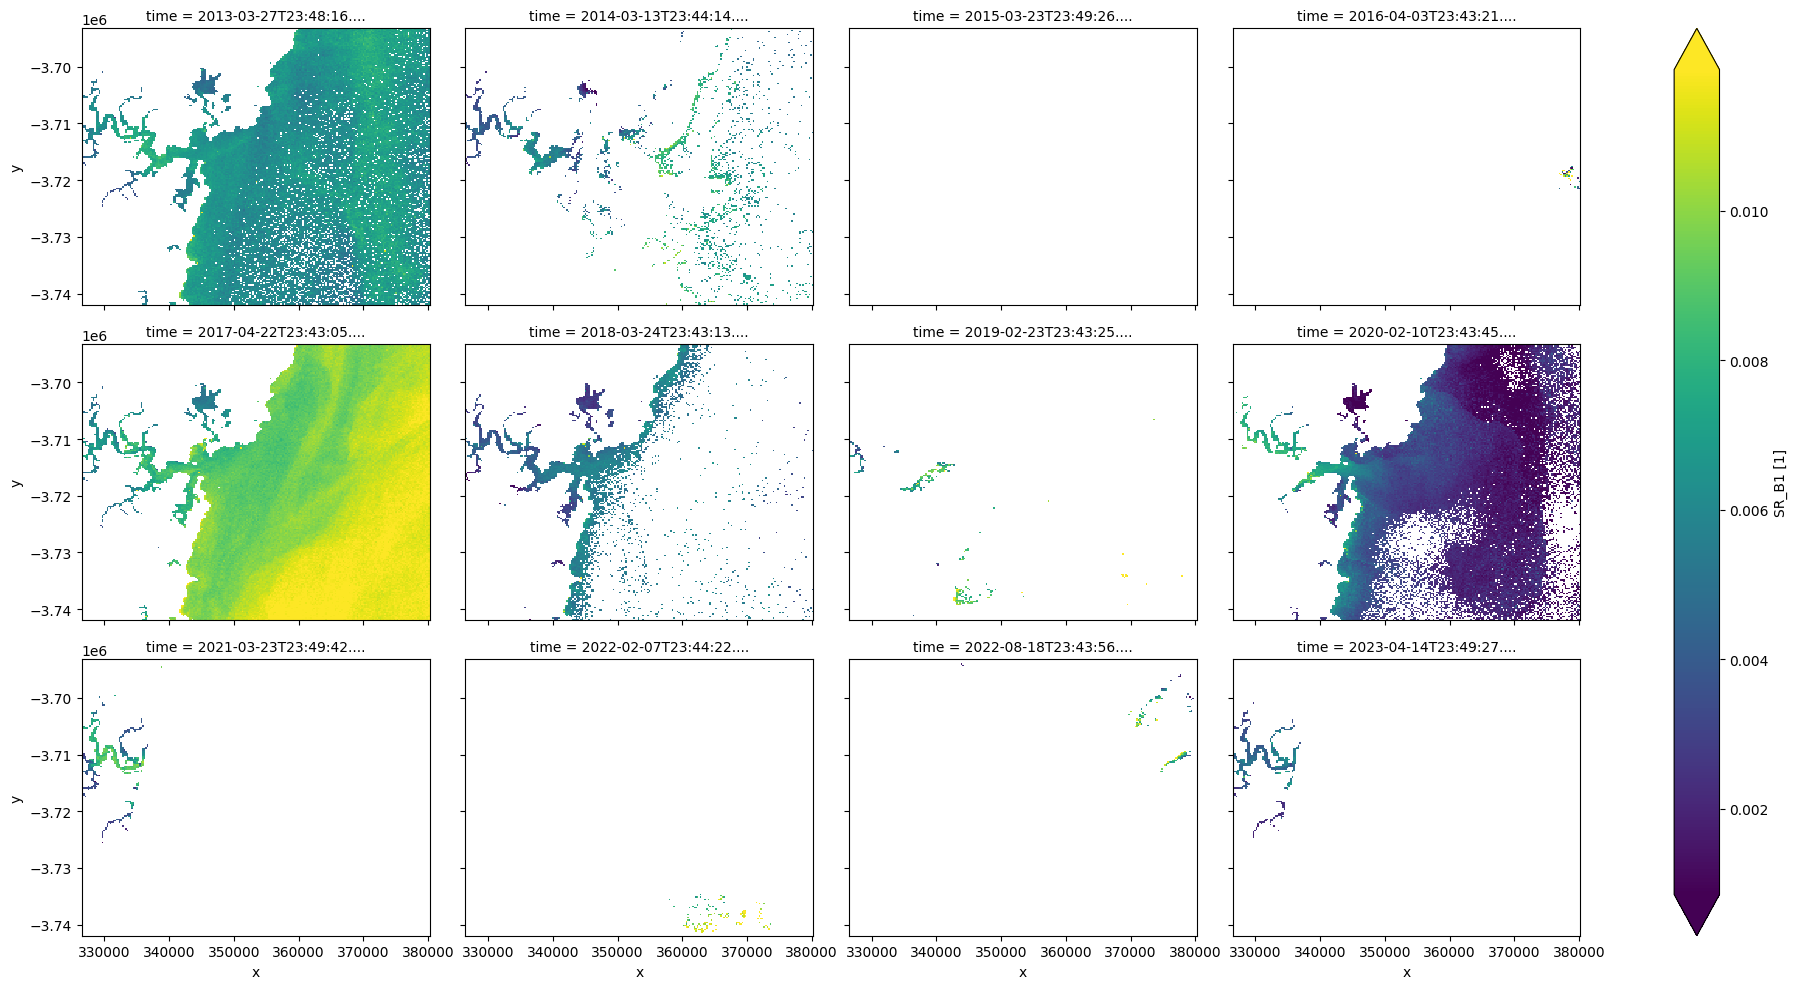

In [13]:
### Some quick plots to double-check raw data
plt_subs = 8   # spatial subsampling increment
plt_ind = np.linspace(1, data.sizes['time'], 12, dtype='int') - 1   # some selected time slices to display
data['SR_B1'][plt_ind,::plt_subs,::plt_subs].plot(col='time', col_wrap=4, figsize=(20,10), robust=True);

## Landsat data pre-processing &amp; WQ algorithm

Band-to-single conversion to be be applied to all LS bands.

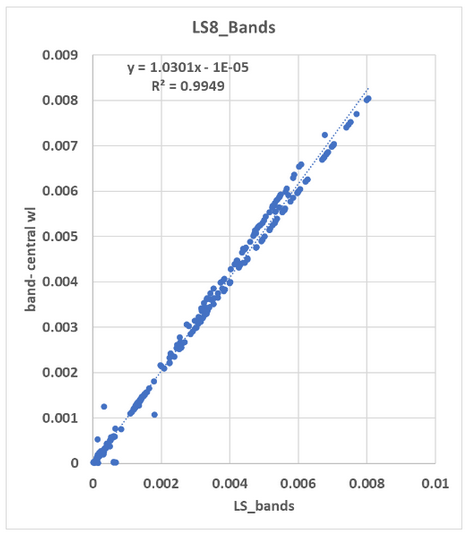

Empirical WQ algorithm to apply to the Landsat data.

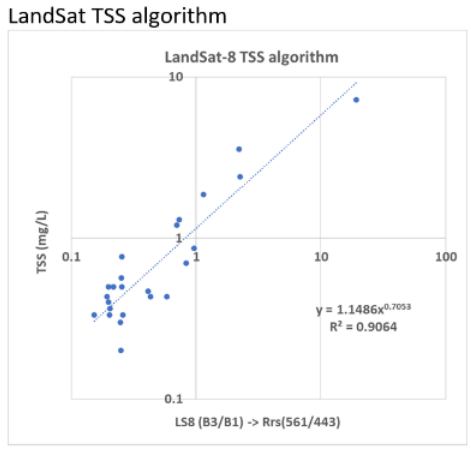

In [14]:
### Apply conversion and empirical WQ algorithms.
data = data * 1.0301 - 0.00001   # applied to each band
data = data.where(data>0)   # filter out negative SR values

data['TSS'] = 1.1486 * pow(data.SR_B3 / data.SR_B1, 0.7053)

In [15]:
### Remove SR bands (not required any longer)
data = data.drop(LS_band_aliases).persist()

In [16]:
### Remove any time slice that only contains NaNs
data = data.dropna('time',how='all').persist()
print( notebook_utils.xarray_object_size(data) )
_ = wait(data)
data

Dataset size: 4.00 GB


<xarray.Dataset>
Dimensions:      (time: 370, y: 1624, x: 1787)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-27T23:48:16.509468 ... 2023-04...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656
Data variables:
    TSS          (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

## Visualise some aspects of the WQ time series

In [17]:
### Generate coastline and land mask for current extents, in projected CRS
tmp = data.TSS[0].rio.reproject('EPSG:4326').rename({'x':'longitude','y':'latitude'})

offset = (-0.006,-0.001)   # fix apparent mis-alignment coastline vs. Landsat (...?!??)
land_mask, shp_poly = get_coastline( ds_lon_vec=tmp.longitude.values, ds_lat_vec=tmp.latitude.values, offset=offset)   #, do_plot=True)#, buf=0.2 )

land_mask.rio.write_crs('EPSG:4326', inplace=True)
land_mask = land_mask.rio.reproject_match( data )
shp_poly = shp_poly.set_crs('EPSG:4326').to_crs(mc_crs)

### Time gaps between observations

In [18]:
tmp = data.time.values
date_start = tmp[0].astype('datetime64[D]')
date_end = tmp[-1].astype('datetime64[D]')
dif = (tmp[-1] - tmp[0]).astype('timedelta64[D]') / np.timedelta64(365, 'D')
print(f"The time series has {len(tmp)} dates ranging from {date_start} until {date_end}.")
print(f"This is equivalent to about {dif:.2f} years.\n")

The time series has 370 dates ranging from 2013-03-27 until 2023-04-14.
This is equivalent to about 10.05 years.



Time gaps in time series (in days): [ 1.  7.  8.  9. 15. 16. 23. 25. 32. 39. 41.]


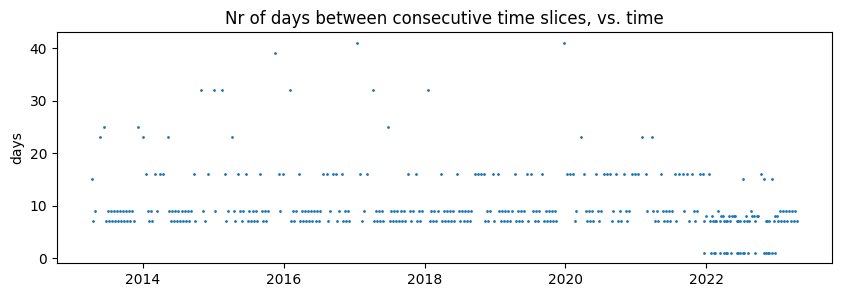

In [19]:
diffvec = np.diff( data.time ) / np.timedelta64(1, 'D')

print(f'Time gaps in time series (in days): {np.unique(np.round(diffvec))}')

plt.figure(figsize=(10,3))
plt.plot(data.time.values[1:], diffvec, 'o', markersize=1)
plt.ylabel('days'); plt.title('Nr of days between consecutive time slices, vs. time');

### Visualise some TSS time slices

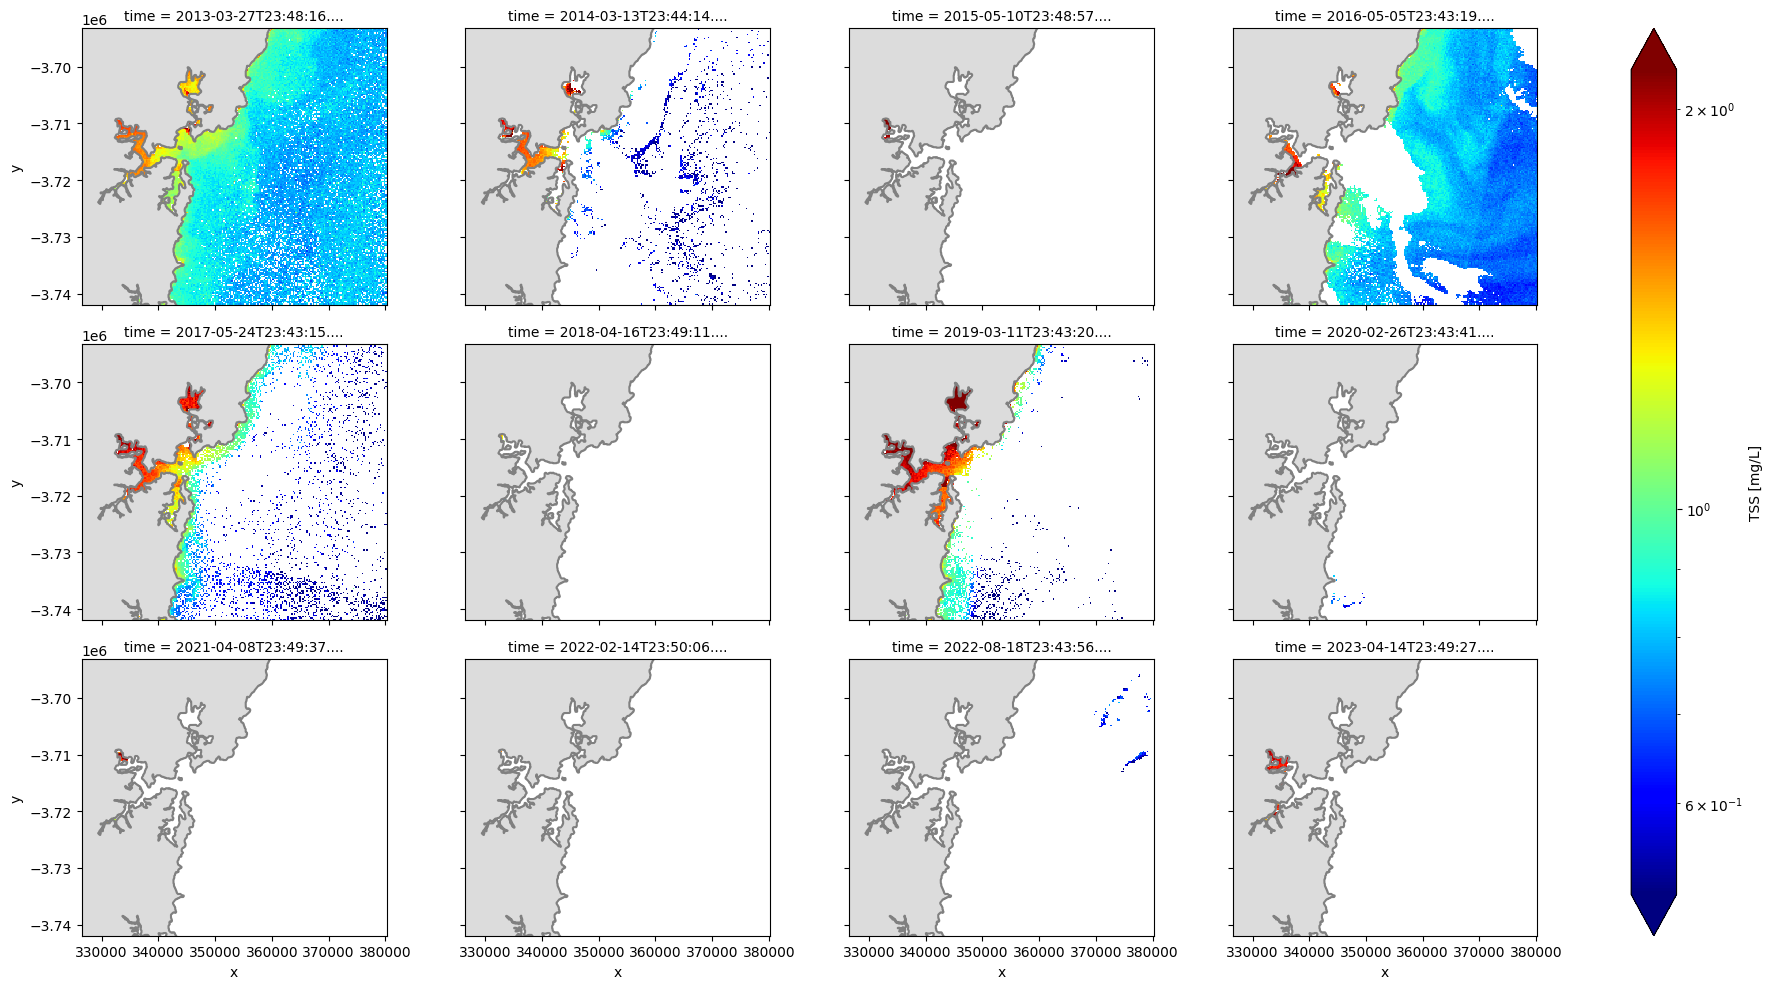

In [20]:
### Some plots to visually check the WQ results
plt_subs = 8   # subsampling increment for plots
plt_ind = np.linspace(1, data.sizes['time'], 12, dtype='int') - 1   # some selected time slices to display
pp = data['TSS'][plt_ind,::plt_subs,::plt_subs].plot( col='time', col_wrap=4, robust=True, norm=norm, cmap=cmap, 
                                                      figsize=(20,10), cbar_kwargs={'label':f'{WQparam} [{WQunits}]'} )

for ii,ax in enumerate(pp.axs.flat):
    ax.set_aspect('equal','box')
    land_mask[::plt_subs,::plt_subs].plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmp)
    shp_poly.boundary.plot(ax=ax, color='grey');

In [21]:
if n_workers is None:  # local Dask cluster
    cluster.close()
    client.shutdown()
else:   # Gateway cluster
    cluster.shutdown()
    client.close()    

In [22]:
### End notebook.